Figures for "Information consumption and firm size" by Lee et al. in RSOS.

Available at https://github.com/eltrompetero/information_consumption.

In [1]:
%matplotlib inline

In [2]:
plt.rc('font', size=25)

In [3]:
from misc.stats import DiscretePowerLaw
from itertools import chain
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.patches import Patch

from workspace.utils import *
from idea_firms.plot import *
from idea_firms import *

imgdr = os.path.expanduser('~')
assert os.path.isdir(imgdr)

# Figure 1: Scaling with capital

In [40]:
def one_plot(i, name, fit=True, y_multiplier=1.):
    # color NAICS code
    utilities_ix = df['def']=='Utilities'
    services_ix = df['def']=='Professional, Scientific, and Technical Services'
    neither_ix = (~utilities_ix)&(~services_ix)
    ax[i].loglog(df['records'].loc[neither_ix], df[name].loc[neither_ix] * y_multiplier, '.',
                 mew=0, alpha=.1, c='gray')
    ax[i].loglog(df['records'].loc[utilities_ix], df[name].loc[utilities_ix] * y_multiplier, '.',
                 mew=0, alpha=.6, c='C1')
    ax[i].loglog(df['records'].loc[services_ix], df[name].loc[services_ix] * y_multiplier, '.',
                 mew=0, alpha=.6, c='C3')
    
    ix = df['records'].isna() | df[name].isna()
    x, y = df['records'].loc[~ix].values, df[name].loc[~ix].values
    ix = (x>=160) & (y>0)

    soln = log_reg(x[ix], y[ix] * y_multiplier, n_boot=10_000)
    print('err', np.std([i[0] for i in soln[1]]))
    
    soln = log_reg(x[ix], y[ix] * y_multiplier)
    
    x = np.array([160, x[ix].max()])
    ax[i].plot(x, x**soln[0] * np.exp(soln[1]), '-', c='k', lw=2)
    
    return soln

load_pickle('cache/capital_scaling.p')

bins = np.logspace(0, 8, 200)
midbins = np.exp((np.log(bins[1:])+np.log(bins[:-1]))/2)
df['log_records'] = np.digitize(df['records'], bins)
df.set_index('domain', inplace=True)

naics = naics_code()
naics_def = pd.read_csv('../data/naics_map.csv', delimiter='\t', index_col='sector')
naics['def'] = naics['naics'].apply(lambda i:naics_def.loc[int(str(i)[:2])])
df = df.join(naics, rsuffix='_naics')

err 0.014218401479600089
[0.725  0.7237]
err 0.01834547551410519
[ 0.819  -2.6306]
err 0.012109220638720672
[0.7927 0.3001]
err 0.013922107834480495
[ 0.8005 -2.1334]


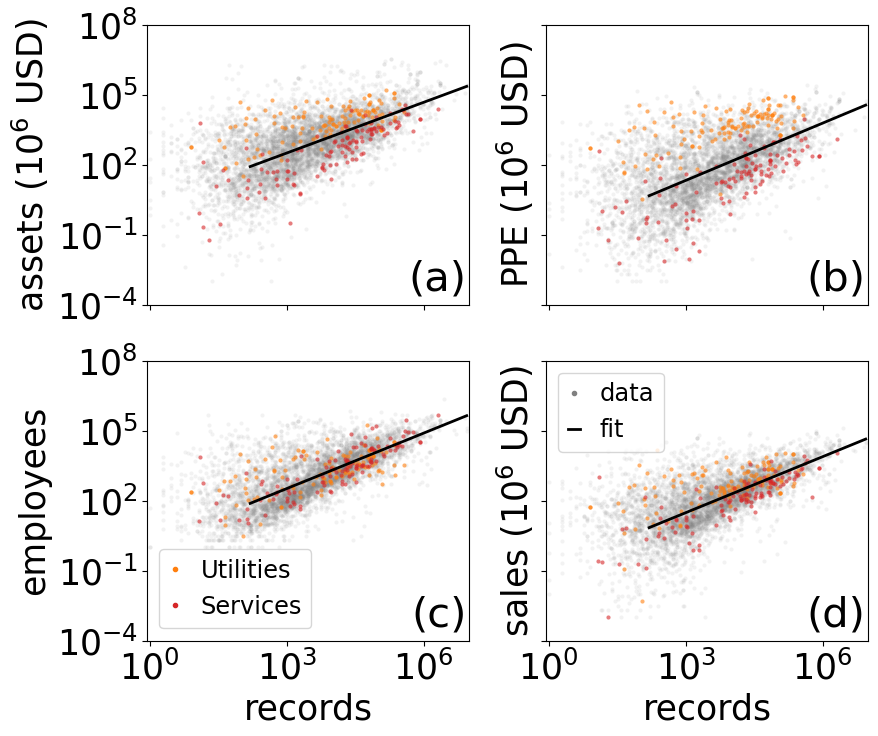

In [41]:
show_median = False

fig, ax = plt.subplots(figsize=(9.3,8), sharex=True, sharey=True,
                       ncols=2, nrows=2, gridspec_kw={'wspace':.24, 'hspace':.2})
ax = ax.ravel()

print(one_plot(0, 'asset'))
print(one_plot(1, 'plantpropertyequipment'))
print(one_plot(2, 'annual_employees', y_multiplier=1000))
print(one_plot(3, 'sales'))

if show_median:
    x, y = df[['records','asset']].dropna().values.T
    ix = (x>=160) & (y>0)
    iplot.median(ax[0], x[ix], y[ix])
    
    x, y = df[['records','plantpropertyequipment']].dropna().values.T
    ix = (x>=160) & (y>0)
    iplot.median(ax[1], x[ix], y[ix])
    
    x, y = df[['records','annual_employees']].dropna().values.T
    ix = (x>=160) & (y>0)
    iplot.median(ax[2], x[ix], y[ix]*1e3)
    
    x, y = df[['records','sales']].dropna().values.T
    ix = (x>=160) & (y>0)
    iplot.median(ax[3], x[ix], y[ix])

ax[0].set(ylabel='assets ($10^6$ USD)', ylim=(1e-4, 1e8), xticks=[1, 1e3, 1e6])
ax[1].set(ylabel='PPE ($10^6$ USD)')
ax[2].set(xlabel='records', ylabel='employees')
ax[3].set(xlabel='records', ylabel=r'sales ($10^6$ USD)')
for a in ax:
    a.set(xlim=(.9, 1e7))

custom_lines = [Line2D([0], [0], color='C1', marker='.', lw=0),
                Line2D([0], [0], color='C3', marker='.', lw=0),]
ax[2].legend(custom_lines, ('Utilities','Services'), fontsize='x-small', handlelength=.5, loc=3)
custom_lines = [Line2D([0], [0], color='gray', marker='.', lw=0),
                Line2D([0], [0], color='k', lw=2),]
ax[3].legend(custom_lines, ('data','fit'), fontsize='x-small', handlelength=.5, loc=2)

ax[0].text(.88e7, 4e-4, '(a)', fontsize='large', ha='right')
ax[1].text(.88e7, 4e-4, '(b)', fontsize='large', ha='right')
ax[2].text(.88e7, 4e-4, '(c)', fontsize='large', ha='right')
ax[3].text(.88e7, 4e-4, '(d)', fontsize='large', ha='right')

fig.savefig(f'{imgdr}/cap_scaling.pdf', bbox_inches='tight')

# Figure 2: Info aggregate scaling

In [12]:
load_pickle('cache/pow_fits.p')

# histograms aggregated over all days
p = {}
xmid = {}
bins = np.logspace(0, 7, 100)
xmid['records'] = np.exp((np.log(bins[1:])+np.log(bins[:-1]))/2)
xmid['article'] = np.exp((np.log(bins[1:])+np.log(bins[:-1]))/2)
xmid['topics'] = np.exp((np.log(bins[1:])+np.log(bins[:-1]))/2)
xmid['source'] = np.exp((np.log(bins[1:])+np.log(bins[:-1]))/2)

# histograms are normalized by bin widths to make them PDFs
p['records'] = hist_firm(bins, '../starter_packet/firehose/201806*/urecords.pq')
p['records'] = p['records'] / p['records'].sum() / np.floor(np.diff(bins)+1)

p['article'] = hist_firm(bins, '../starter_packet/firehose/201806*/uarticle.pq')
p['article'] = p['article'] / p['article'].sum() / np.floor(np.diff(bins)+1)

p['source'] = hist_firm(bins, '../starter_packet/firehose/201806*/usource.pq')
p['source'] = p['source'] / p['source'].sum() / np.floor(np.diff(bins)+1)

p['topics'] = hist_firm_topics(bins)
p['topics'] = p['topics'] / p['topics'].sum() / np.floor(np.diff(bins)+1)

econdf = read_and_econ_df()
naics = naics_code()
naics_def = pd.read_csv('../data/naics_map.csv', delimiter='\t', index_col='sector')
naics['def'] = naics['naics'].apply(lambda i:naics_def.loc[int(str(i)[:2])])
econdf = econdf.join(naics, rsuffix='_naics')

records [ 0.8005 -2.1334]
articles [ 0.8471 -1.8704]
source [ 1.0337 -2.2859]
topic [ 1.1617 -3.7268]


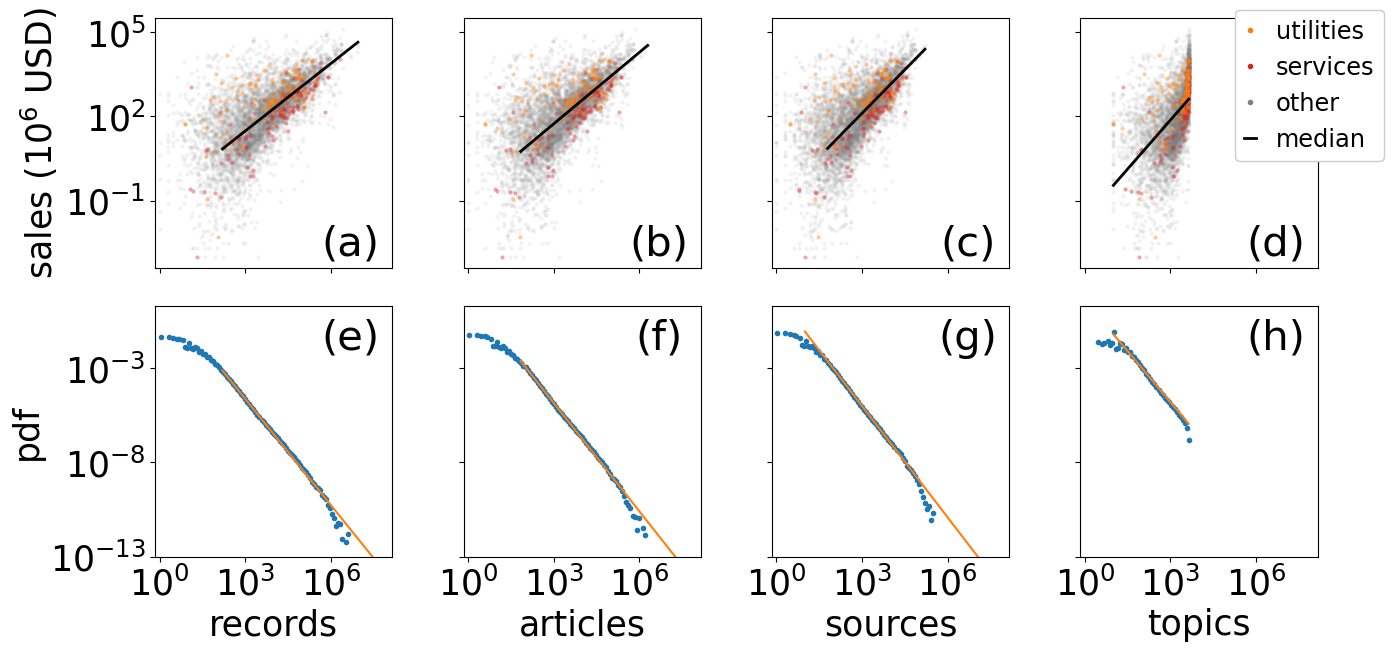

In [13]:
show_median = False

fig, ax = plt.subplots(figsize=(15,7), nrows=2, ncols=4, gridspec_kw={'hspace':.15,'wspace':.3}, sharex=True)
ax = ax[::-1]
ax = ax.ravel()

ax[0].loglog(xmid['records'], p['records'], '.')
ax[1].loglog(xmid['article'], p['article'], '.')
ax[2].loglog(xmid['source'], p['source'], '.')
ax[3].loglog(xmid['topics'], p['topics'], '.')


dpl = DiscretePowerLaw(alpha=record_pow_fit['alpha'], lower_bound=record_pow_fit['lb'])
x = np.array([record_pow_fit['lb'], 1e8])
ax[0].loglog(x, dpl.pdf()(x) * record_pow_fit['f'], '-', c='C1')

dpl = DiscretePowerLaw(alpha=article_pow_fit['alpha'], lower_bound=article_pow_fit['lb'])
x = np.array([article_pow_fit['lb'], 1e8])
ax[1].loglog(x, dpl.pdf()(x) * article_pow_fit['f'], '-', c='C1')

dpl = DiscretePowerLaw(alpha=source_pow_fit['alpha'], lower_bound=source_pow_fit['lb'])
x = np.array([10, 1e8])
ax[2].loglog(x, dpl.pdf()(x) * source_pow_fit['f'], '-', c='C1')

dpl = DiscretePowerLaw(alpha=topic_pow_fit['alpha'], lower_bound=topic_pow_fit['lb'])
x = np.array([10, count_topics()])
ax[3].loglog(x, dpl.pdf()(x) * topic_pow_fit['f'], '-', c='C1')
f = hist_firm_topics(np.array([1, 10, 1e10]))
f = f[1] / f.sum()

ax[0].set(ylabel='pdf', ylim=(1e-13, 2),
          xticks=10**np.arange(0,9,3))
ax[1].set(xticks=10**np.arange(0,9,3), ylim=(1e-13, 2), yticklabels=[])
ax[2].set(xticks=10**np.arange(0,9,3), ylim=(1e-13, 2), yticklabels=[])
ax[3].set(xticks=10**np.arange(0,9,3), ylim=(1e-13, 2), yticklabels=[])

h = []
# color NAICS code
utilities_ix = econdf['def']=='Utilities'
services_ix = econdf['def']=='Professional, Scientific, and Technical Services'
neither_ix = (~utilities_ix) & (~services_ix)

ax[4].loglog(econdf['records'].loc[neither_ix], econdf['sales'].loc[neither_ix], '.',
             alpha=.1, mew=0, c='gray')
ax[4].loglog(econdf['records'].loc[services_ix], econdf['sales'].loc[services_ix], '.',
             alpha=.4, mew=0, c='C3')
ax[4].loglog(econdf['records'].loc[utilities_ix], econdf['sales'].loc[utilities_ix], '.',
             alpha=.4, mew=0, c='C1')

ax[5].loglog(econdf['article'].loc[neither_ix], econdf['sales'].loc[neither_ix], '.',
             alpha=.1, mew=0, c='gray')
ax[5].loglog(econdf['article'].loc[services_ix], econdf['sales'].loc[services_ix], '.',
             alpha=.4, mew=0, c='C3')
ax[5].loglog(econdf['article'].loc[utilities_ix], econdf['sales'].loc[utilities_ix], '.',
             alpha=.4, mew=0, c='C1')

ax[6].loglog(econdf['source'].loc[neither_ix], econdf['sales'].loc[neither_ix], '.',
             alpha=.1, mew=0, c='gray')
ax[6].loglog(econdf['source'].loc[services_ix], econdf['sales'].loc[services_ix], '.',
             alpha=.4, mew=0, c='C3')
ax[6].loglog(econdf['source'].loc[utilities_ix], econdf['sales'].loc[utilities_ix], '.',
             alpha=.4, mew=0, c='C1')

ax[7].loglog(econdf['topics'].loc[neither_ix], econdf['sales'].loc[neither_ix], '.',
             alpha=.1, mew=0, c='gray')
ax[7].loglog(econdf['topics'].loc[services_ix], econdf['sales'].loc[services_ix], '.',
             alpha=.4, mew=0, c='C3')
ax[7].loglog(econdf['topics'].loc[utilities_ix], econdf['sales'].loc[utilities_ix], '.',
             alpha=.4, mew=0, c='C1')

x, y = econdf[['records','sales']].dropna().values.T
ix = (x>=record_pow_fit['lb']) & (y>0)
soln = log_reg(x[ix], y[ix])
print('records', soln)
if show_median: h.append(iplot.median(ax[4], x[ix], y[ix]))

x = np.array([record_pow_fit['lb'], x[ix].max()])
h.append(ax[4].plot(x, x**soln[0] * np.exp(soln[1]), '-', c='k', lw=2)[0])

x, y = econdf[['article','sales']].dropna().values.T
ix = (x>=article_pow_fit['lb']) & (y>0)
soln = log_reg(x[ix], y[ix])
print('articles', soln)
if show_median: iplot.median(ax[5], x[ix], y[ix])

x = np.array([article_pow_fit['lb'], x[ix].max()])
ax[5].plot(x, x**soln[0] * np.exp(soln[1]), '-', c='k', lw=2)

x, y = econdf[['source','sales']].dropna().values.T
ix = (x>=source_pow_fit['lb']) & (y>0)
soln = log_reg(x[ix], y[ix])
print('source', soln)
if show_median: iplot.median(ax[6], x[ix], y[ix])

x = np.array([source_pow_fit['lb'], x[ix].max()])
ax[6].plot(x, x**soln[0] * np.exp(soln[1]), '-', c='k', lw=2)

x, y = econdf[['topics','sales']].dropna().values.T
ix = (x>9) & (y>0)
soln = log_reg(x[ix], y[ix])
print('topic', soln)
if show_median: iplot.median(ax[7], x[ix], y[ix])

x = np.array([topic_pow_fit['lb'], x[ix].max()])
ax[7].plot(x, x**soln[0] * np.exp(soln[1]), '-', c='k', lw=2)

ax[0].set(xlabel='records')
ax[1].set(xlabel='articles')
ax[2].set(xlabel='sources')
ax[3].set(xlabel='topics')
ax[4].set(ylabel='sales ($10^6$ USD)', xticks=10**np.arange(0,7,3), xlim=(.7,1e8/.7))
ax[5].set(yticklabels=[], xticks=10**np.arange(0,7,3))
ax[6].set(yticklabels=[], xticks=10**np.arange(0,7,3))
ax[7].set(yticklabels=[], xticks=10**np.arange(0,7,3))

ax[4].text(5e6, 1.2e-3, '(a)', fontsize='large', ha='center')
ax[5].text(5e6, 1.2e-3, '(b)', fontsize='large', ha='center')
ax[6].text(5e6, 1.2e-3, '(c)', fontsize='large', ha='center')
ax[7].text(5e6, 1.2e-3, '(d)', fontsize='large', ha='center')
ax[0].text(5e6, 1e-2, '(e)', fontsize='large', ha='center')
ax[1].text(5e6, 1e-2, '(f)', fontsize='large', ha='center')
ax[2].text(5e6, 1e-2, '(g)', fontsize='large', ha='center')
ax[3].text(5e6, 1e-2, '(h)', fontsize='large', ha='center');

custom_lines = [Line2D([0], [0], color='C1', marker='.', lw=0),
                Line2D([0], [0], color='C3', marker='.', lw=0),
                Line2D([0], [0], color='gray', marker='.', lw=0)]
ax[7].legend(custom_lines+h, ('utilities', 'services', 'other', 'median', 'fit'), fontsize='x-small',
             handlelength=.5,
             loc=2,
             bbox_to_anchor=(.6,1.08),
             framealpha=1)

fig.savefig(f'{imgdr}/power_laws.pdf', bbox_inches='tight')

In [14]:
record_pow_fit['alpha'], record_pow_fit['alpha_samp'].std(), record_pow_fit['lb']

(1.879320079086222, 0.005269156485444995, 160)

In [15]:
article_pow_fit['alpha'], article_pow_fit['alpha_samp'].std(), article_pow_fit['lb']

(1.9177571805827116, 0.00403928217471641, 70)

In [16]:
source_pow_fit['alpha'], source_pow_fit['alpha_samp'].std(), source_pow_fit['lb']

(1.9724139355580972, 0.005224759567040383, 62)

In [17]:
topic_pow_fit['alpha'], topic_pow_fit['alpha_samp'].std(), topic_pow_fit['lb']

(1.8019194200717863, 0.0008166104244028438, 10)

In [29]:
x, y = econdf[['records','sales']].dropna().values.T
ix = (x>=record_pow_fit['lb']) & (y>0)
soln = log_reg(x[ix], y[ix], n_boot=10_000)
print(np.std([i[0] for i in soln[1]]))

x, y = econdf[['article','sales']].dropna().values.T
ix = (x>=article_pow_fit['lb']) & (y>0)
soln = log_reg(x[ix], y[ix], n_boot=10_000)
print(np.std([i[0] for i in soln[1]]))

x, y = econdf[['source','sales']].dropna().values.T
ix = (x>=source_pow_fit['lb']) & (y>0)
soln = log_reg(x[ix], y[ix])
soln = log_reg(x[ix], y[ix], n_boot=10_000)
print(np.std([i[0] for i in soln[1]]))

x, y = econdf[['topics','sales']].dropna().values.T
ix = (x>9) & (y>0)
soln = log_reg(x[ix], y[ix], n_boot=10_000)
print(np.std([i[0] for i in soln[1]]))

0.013964003538810502
0.01448318688679861
0.018041187266641452
0.03350243008104256


In [19]:
def reading_econ_fitter(x_var, y_var, n_boot=1000):
    """
    Parameters
    ----------
    x_var : str
        Any of 'records', 'article', 'source', 'topics'.
    y_var : str
        Any of 'asset', 'annual_employees', 'plantpropertyequipment', 'sales'.
    n_boot : int, 1000
        Number of bootstrap samples.
    
    Returns
    -------
    float
        Fit exponent.
    float
        Error as standard dev over bootstraps.
    float
        Fit intercept as log.
    float
        Error as standard dev over bootstraps for intercept.
    """
    # lower limits found from CSN procedure fitting power laws
    if x_var=='records':
        xmn = record_pow_fit['lb']
    elif x_var=='article':
        xmn = article_pow_fit['lb']
    elif x_var=='source':
        xmn = source_pow_fit['lb']
    elif x_var=='topics':
        xmn = 10
    else:
        raise NotImplementedError
    if not y_var in ('asset', 'annual_employees', 'plantpropertyequipment', 'sales'):
        raise NotImplementedError
        
    x, y = econdf[[x_var,y_var]].dropna().values.T
    ix = (x>=xmn) & (y>0)
    ix[x.argmax()] = False
    soln, boot_soln = log_reg(x[ix], y[ix], n_boot=n_boot)
    return (soln[0], np.std([i[0] for i in boot_soln])), (soln[1], np.std([i[1] for i in boot_soln]))

In [20]:
fit_df = []
for x in ['records', 'article', 'source', 'topics']:
    fit_df.append([])
    for y in ['asset', 'plantpropertyequipment', 'annual_employees', 'sales']:
        fit_df[-1].append([np.around(i, 2) for i in reading_econ_fitter(x, y)])

fit_df = pd.DataFrame(fit_df, index=['records', 'article', 'source', 'topics'],
                      columns=['asset', 'PPE', 'annual_employees', 'sales'])

In [21]:
fit_df

,asset,PPE,annual_employees,sales
records,"[[0.73, 0.01], [0.72, 0.13]]","[[0.82, 0.02], [-2.63, 0.18]]","[[0.79, 0.01], [-6.61, 0.12]]","[[0.8, 0.01], [-2.13, 0.14]]"
article,"[[0.77, 0.01], [0.94, 0.13]]","[[0.88, 0.02], [-2.46, 0.18]]","[[0.85, 0.01], [-6.43, 0.12]]","[[0.85, 0.01], [-1.87, 0.13]]"
source,"[[0.91, 0.02], [0.77, 0.15]]","[[1.07, 0.02], [-2.89, 0.18]]","[[1.02, 0.02], [-6.73, 0.13]]","[[1.03, 0.02], [-2.28, 0.14]]"
topics,"[[1.11, 0.03], [-1.16, 0.22]]","[[1.16, 0.04], [-4.01, 0.29]]","[[1.16, 0.03], [-8.25, 0.22]]","[[1.16, 0.03], [-3.72, 0.26]]"


In [45]:
R = 18

sol = iplot.fit_records_econ_scaling(econdf)[0]
print(R**sol[0] * np.exp(sol[1]))

sol = iplot.fit_records_econ_scaling(econdf)[-1]
print(R**sol[0] * np.exp(sol[1]))

16.76312204597297
1.1978013024518692


# Figure 3: Topic scaling

In [23]:
load_pickle('cache/heaps_fit.p')
load_pickle('cache/heaps_df.p')

bins = np.unique(np.around(np.logspace(0, 8, 200)))
articledf['log_domain_counts'] = np.digitize(articledf['domain_counts'], bins)-1
sourcedf['log_domain_counts'] = np.digitize(sourcedf['domain_counts'], bins)-1
topicdf['log_domain_counts'] = np.digitize(topicdf['domain_counts'], bins)-1

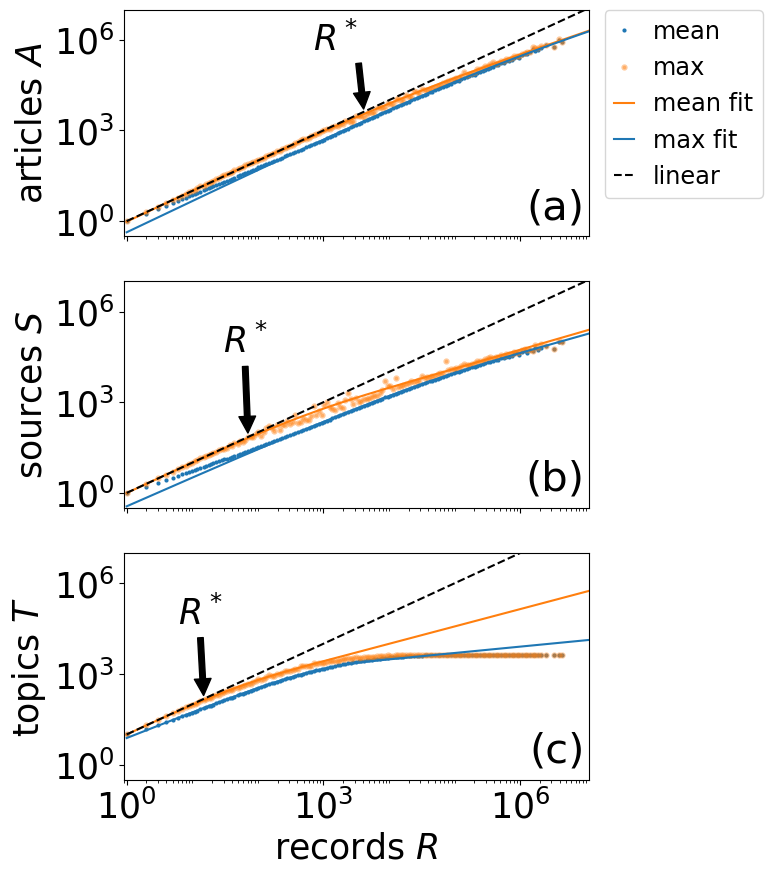

In [24]:
show_min = False  # show min diversity data points

fig, ax = plt.subplots(figsize=(6,10), sharey=True, sharex=True, nrows=3,
                       gridspec_kw={'wspace':.5})
xplot = np.logspace(0, 7.3, 200)

# group only source_counts
group = articledf.iloc[:,2:].groupby('log_domain_counts')

m_xy = group.mean().reset_index().values
ax[0].loglog(bins[m_xy[:,0].astype(int)], m_xy[:,1], '.',
               mew=0, zorder=0)
max_xy = group.max().reset_index().values
ax[0].loglog(bins[max_xy[:,0].astype(int)], max_xy[:,1], '.',
               mew=2, ms=5, alpha=.4, zorder=1)
if show_min:
    min_xy = group.min().reset_index().values
    ix = min_xy[:,1]>1
    ax[0].loglog(bins[min_xy[:,0].astype(int)][ix], min_xy[:,1][ix], '.',
                   mew=2, ms=5, alpha=.4, zorder=1)

ax[0].loglog(xplot, fitter[0].f(xplot), '-', c='C1')
ax[0].loglog(xplot, fitter[1].f(xplot), '-', c='C0')

x = np.array([sourcedf['domain_counts'].min(), sourcedf['domain_counts'].max()])
ax[0].plot([1,1e7], [1,1e7], 'k--')
ax[0].annotate(r"$R^*$", xy=(4150, 4150), xytext=(700, 1e6),
               ha='left', va='center',
               arrowprops=dict(facecolor='k', shrink=.05))


# group only source_counts
group = sourcedf.iloc[:,2:].groupby('log_domain_counts')

m_xy = group.mean().reset_index().values
ax[1].loglog(bins[m_xy[:,0].astype(int)], m_xy[:,1], '.',
          mew=0, zorder=0)
max_xy = group.max().reset_index().values
ax[1].loglog(bins[max_xy[:,0].astype(int)], max_xy[:,1], '.',
          mew=2, ms=5, alpha=.4, zorder=1)
if show_min:
    min_xy = group.min().reset_index().values
    ix = min_xy[:,1]>1
    ax[1].loglog(bins[min_xy[:,0].astype(int)][ix], min_xy[:,1][ix], '.',
              mew=2, ms=5, alpha=.4, zorder=1)

ax[1].loglog(xplot, fitter[2].f(xplot), '-', c='C1')
ax[1].loglog(xplot, fitter[3].f(xplot), '-', c='C0')

x = np.array([sourcedf['domain_counts'].min(), sourcedf['domain_counts'].max()])
ax[1].plot([1,1e7], [1,1e7], 'k--')
ax[1].annotate(r"$R^*$", xy=(71, 71), xytext=(29, 1e5),
               ha='left', va='center',
               arrowprops=dict(facecolor='k', shrink=.05))


# group only topic_counts
group = topicdf.iloc[:,2:].groupby('log_domain_counts')

m_xy = group.mean().reset_index().values
ax[2].loglog(bins[m_xy[:,0].astype(int)], m_xy[:,1], '.',
               mew=0, zorder=0)
max_xy = group.max().reset_index().values
ax[2].loglog(bins[max_xy[:,0].astype(int)], max_xy[:,1], '.',
               mew=2, ms=5, alpha=.4, zorder=1)
if show_min:
    min_xy = group.min().reset_index().values
    ix = min_xy[:,1]>1
    ax[2].loglog(bins[min_xy[:,0].astype(int)][ix], min_xy[:,1][ix], '.',
                   mew=2, ms=5, alpha=.4, zorder=1)

# only consider points far from the cutoff
x = bins[m_xy[:,0].astype(int)][10:41]
y = m_xy[:,1][10:41]
ax[2].loglog(xplot, fitter[4].f(xplot)*10, '-', c='C1')
x = bins[max_xy[:,0].astype(int)][:41]
y = max_xy[:,1][:41]
ax[2].loglog(xplot, fitter[5].f(xplot)*10, '-', c='C0')

x = np.array([topicdf['domain_counts'].min(), topicdf['domain_counts'].max()])
ax[2].plot([1,1e7], [10,1e8], 'k--')
ax[2].annotate(r"$R^*$", xy=(15, 150), xytext=(6, 1e5),
               ha='left', va='center',
               arrowprops=dict(facecolor='k', shrink=.05))


ax[0].set(ylabel=r'articles $A$', yticks=[1,1e3,1e6], ylim=(.322, 1e7))
ax[1].set(ylabel=r'sources $S$')
ax[2].set(xlabel=r'records $R$', ylabel=r'topics $T$',
            xticks=10**np.arange(0, 7, 3), xlim=(.9,1e7/.9))
locmin = mpl.ticker.LogLocator(base=10.0,subs=np.arange(1, 10)*.1, numticks=12)
ax[2].xaxis.set_minor_locator(locmin)
ax[2].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax[0].legend(('mean', 'max', 'mean fit', 'max fit', 'linear'),
               fontsize='x-small', handlelength=.8, columnspacing=1, loc=1, bbox_to_anchor=(1.4,1.05))

ax[0].text(.96e7, 1.2, '(a)', fontsize='large', ha='right')
ax[1].text(.96e7, 1.2, '(b)', fontsize='large', ha='right')
ax[2].text(.96e7, 1.2, '(c)', fontsize='large', ha='right')

fig.savefig(f'{imgdr}/heaps.pdf', bbox_inches='tight')

In [25]:
# group only source_counts
group = articledf.iloc[:,2:].groupby('log_domain_counts')
max_xy = group.max().reset_index().values
ix = np.argmax((max_xy[:,1]/bins[max_xy[:,0].astype(int)]) < .9)
print('article crossing', bins[max_xy[ix,0].astype(int)])

# group only source_counts
group = sourcedf.iloc[:,2:].groupby('log_domain_counts')
max_xy = group.max().reset_index().values
ix = np.argmax((max_xy[:,1]/bins[max_xy[:,0].astype(int)]) < .9)
print('source crossing', bins[max_xy[ix,0].astype(int)])
      
# group only topic_counts
group = topicdf.iloc[:,2:].groupby('log_domain_counts')
max_xy = group.max().reset_index().values
ix = np.argmax((max_xy[:,1]/10/bins[max_xy[:,0].astype(int)]) < .9)
print('topics crossing', bins[max_xy[ix,0].astype(int)])

article crossing 1645.0
source crossing 41.0
topics crossing 18.0


In [26]:
group = topicdf.iloc[:,2:].groupby('log_domain_counts')
max_xy = group.max().reset_index().values

ix = np.where(max_xy[:,1]<fitter[4].f(bins[max_xy[:,0].astype(int)])*9)[0][0]
print(f'Records R at which topics data falls below model, {bins[max_xy[:,0].astype(int)][ix]}')

Records R at which topics data falls below model, 652.0


# Figure 4: Extensive vs. intensive ratio

In [46]:
load_pickle('cache/heaps_fit.p')
load_pickle('cache/heaps_fitting_variation.p')

['m_opt_ix',
 'm_err',
 'mx_opt_ix',
 'mx_err',
 'a_mean',
 'a_max',
 'b_mean',
 'b_max',
 'lower_range',
 'upper_range',
 'fit_criterion_ix']

In [47]:
econdf = read_and_econ_df('201806*')
naics = naics_code()
naics_def = pd.read_csv('../data/naics_map.csv', delimiter='\t', index_col='sector')
naics['def'] = naics['naics'].apply(lambda i:naics_def.loc[int(str(i)[:2])])
econdf = econdf.join(naics, rsuffix='_naics')

fit_params = fit_records_econ_scaling(econdf)

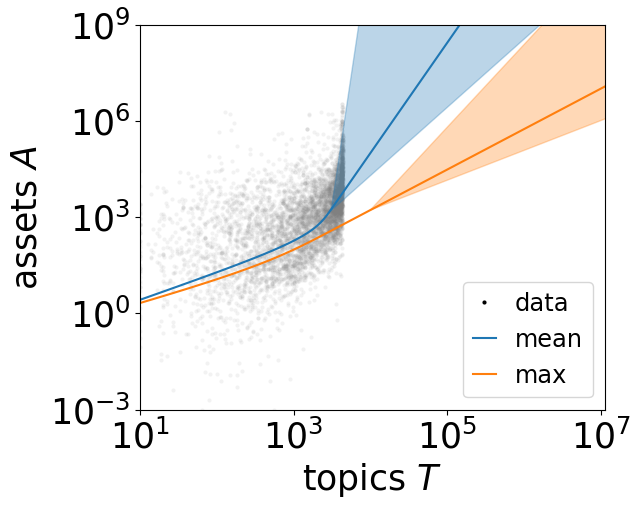

In [48]:
fig, ax = plt.subplots(figsize=(6,5))
h = []

h.append(ax.loglog(econdf['topics'], econdf['asset'], '.', mew=0, c='gray', alpha=.1, zorder=-1)[0])

R = np.logspace(0, 15, 100)
R_cutoff = np.logspace(4, 15, 2)

# mean diversity
h.append(ax.loglog(fitter[-1].f(R)*10, np.exp(fit_params[0][1])*R**fit_params[0][0], '-')[0])
mn_exp = np.percentile(a_mean[fit_criterion_ix], 2.5)
mx_exp = np.percentile(a_mean[fit_criterion_ix], 97.5)
x_below = R_cutoff**mx_exp/R_cutoff[0]**mx_exp * fitter[-1].f(R_cutoff[0])*10
x_above = R_cutoff**mn_exp/R_cutoff[0]**mn_exp * fitter[-1].f(R_cutoff[0])*10
ax.fill_betweenx(np.exp(fit_params[0][1])*R_cutoff**fit_params[0][0], x_below, x_above, alpha=.3, color='C0', zorder=2)

# max diversity
h.append(ax.loglog(fitter[-2].f(R)*10, np.exp(fit_params[0][1])*R**fit_params[0][0], '-')[0])
mn_exp = np.percentile(a_max[fit_criterion_ix], 2.5)
mx_exp = np.percentile(a_max[fit_criterion_ix], 97.5)
x_above = R_cutoff**mn_exp/R_cutoff[0]**mn_exp * fitter[-2].f(R_cutoff[0])*10
x_below = R_cutoff**mx_exp/R_cutoff[0]**mx_exp * fitter[-2].f(R_cutoff[0])*10
ax.fill_betweenx(np.exp(fit_params[0][1])*R_cutoff**fit_params[0][0], x_below, x_above, alpha=.3, color='C1', zorder=2)

ax.set(xlabel=r'topics $T$', ylabel=r'assets $A$', xlim=(10, 1e7/.9), ylim=(1e-3, 1e9))
ax.legend([Line2D([0], [0], marker='.', mew=0, c='k', lw=0)] + h[1:],
          ('data', r'mean', f'max', r'$T^{0.76}$', r'$T$', r'$T^{3/2}$'),
          handlelength=.95, fontsize='x-small')

fig.savefig(f'{imgdr}/info_strategies.pdf', bbox_inches='tight')

# Supplementary figures

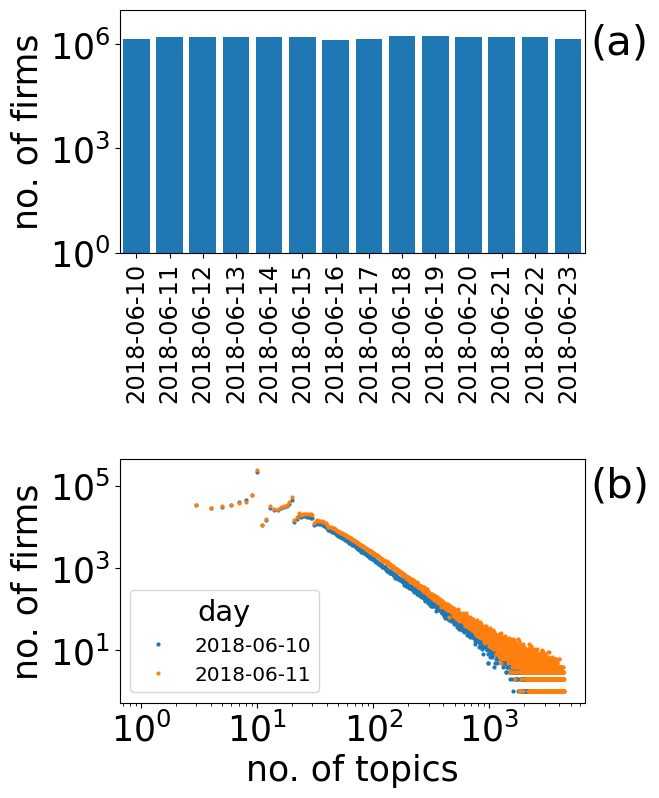

In [66]:
load_pickle('cache/basic_info.p')

fig, ax = plt.subplots(figsize=(6,9), nrows=2, gridspec_kw={'hspace':.85})
ax = ax.ravel()

# no. of recorded firms per day
ax[0].bar(range(len(nfirms)), nfirms)
ax[0].set(xticks=range(len(nfirms)), yscale='log', ylim=(1, 1e7),
          ylabel='no. of firms',
          xlim=(-.5,len(nfirms)-.5))
ax[0].yaxis.set_minor_formatter('')
ax[0].xaxis.set_ticklabels([f'2018-06-{day}' for day in range(10, 10+len(nfirms))],
                           rotation=90,
                           fontsize='x-small');

# no. of topics by firm
n = np.bincount(ntopics[0])
ax[1].plot(range(n.size), n, '.', mew=0)

n = np.bincount(ntopics[1])
ax[1].plot(range(n.size), n, '.', mew=0)

leg = ax[1].legend(('2018-06-10','2018-06-11'), fontsize='xx-small')
leg.set_title('day', prop={'size':'small'})
ax[1].set(xscale='log', yscale='log', xlabel='no. of topics', ylabel='no. of firms')

fig.text(.91, .83, '(a)', fontsize='large', ha='left')
fig.text(.91, .338, '(b)', fontsize='large', ha='left')

fig.savefig(f'{imgdr}/topic_summary.pdf', bbox_inches='tight')

## Error bars

In [53]:
load_pickle('cache/capital_scaling.p')

bins = np.logspace(0, 8, 200)
midbins = np.exp((np.log(bins[1:])+np.log(bins[:-1]))/2)
df['log_records'] = np.digitize(df['records'], bins)
df.set_index('domain', inplace=True)

naics = naics_code()
naics_def = pd.read_csv('../data/naics_map.csv', delimiter='\t', index_col='sector')
naics['def'] = naics['naics'].apply(lambda i:naics_def.loc[int(str(i)[:2])])
df = df.join(naics, rsuffix='_naics')

In [54]:
def one_plot(i, name, fit=True, y_multiplier=1.):
    # color NAICS code
    utilities_ix = df['def']=='Utilities'
    services_ix = df['def']=='Professional, Scientific, and Technical Services'
    neither_ix = (~utilities_ix)&(~services_ix)
    ax[i].loglog(df['records'].loc[neither_ix], df[name].loc[neither_ix] * y_multiplier, '.',
                 mew=0, alpha=.1, c='gray')
    ax[i].loglog(df['records'].loc[utilities_ix], df[name].loc[utilities_ix] * y_multiplier, '.',
                 mew=0, alpha=.6, c='C1')
    ax[i].loglog(df['records'].loc[services_ix], df[name].loc[services_ix] * y_multiplier, '.',
                 mew=0, alpha=.6, c='C3')
    
    ix = df['records'].isna() | df[name].isna()
    x, y = df['records'].loc[~ix].values, df[name].loc[~ix].values
    ix = (x>=160) & (y>0)
    soln = log_reg(y[ix] * y_multiplier, x[ix])
    
    x = (np.array([160, x[ix].max()]) * np.exp(-soln[1]))**(1/soln[0])
    ax[i].plot(x**soln[0] * np.exp(soln[1]), x, '-', c='k', lw=2)
    
    return soln

[0.5124 5.1078]
[0.3922 6.9925]
[0.6249 4.2545]
[0.5594 6.0625]


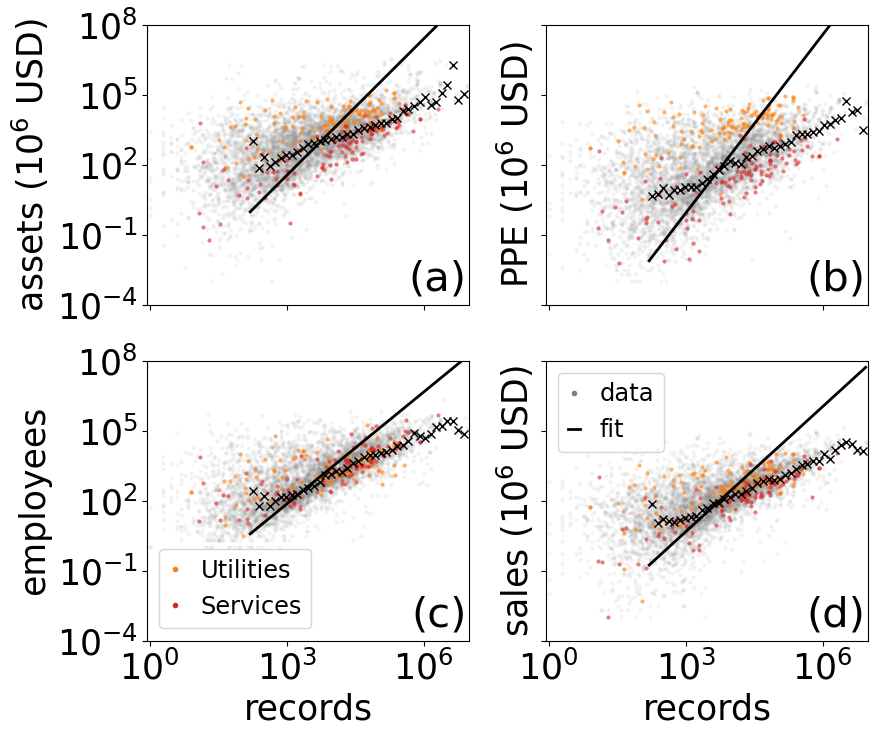

In [55]:
show_median = True

fig, ax = plt.subplots(figsize=(9.3,8), sharex=True, sharey=True,
                       ncols=2, nrows=2, gridspec_kw={'wspace':.24, 'hspace':.2})
ax = ax.ravel()

print(one_plot(0, 'asset'))
print(one_plot(1, 'plantpropertyequipment'))
print(one_plot(2, 'annual_employees', y_multiplier=1000))
print(one_plot(3, 'sales'))

if show_median:
    x, y = df[['records','asset']].dropna().values.T
    ix = (x>=160) & (y>0)
    iplot.median(ax[0], x[ix], y[ix])
    
    x, y = df[['records','plantpropertyequipment']].dropna().values.T
    ix = (x>=160) & (y>0)
    iplot.median(ax[1], x[ix], y[ix])
    
    x, y = df[['records','annual_employees']].dropna().values.T
    ix = (x>=160) & (y>0)
    iplot.median(ax[2], x[ix], y[ix]*1e3)
    
    x, y = df[['records','sales']].dropna().values.T
    ix = (x>=160) & (y>0)
    iplot.median(ax[3], x[ix], y[ix])

ax[0].set(ylabel='assets ($10^6$ USD)', ylim=(1e-4, 1e8), xticks=[1, 1e3, 1e6])
ax[1].set(ylabel='PPE ($10^6$ USD)')
ax[2].set(xlabel='records', ylabel='employees')
ax[3].set(xlabel='records', ylabel=r'sales ($10^6$ USD)')
for a in ax:
    a.set(xlim=(.9, 1e7))

custom_lines = [Line2D([0], [0], color='C1', marker='.', lw=0),
                Line2D([0], [0], color='C3', marker='.', lw=0),]
ax[2].legend(custom_lines, ('Utilities','Services'), fontsize='x-small', handlelength=.5, loc=3)
custom_lines = [Line2D([0], [0], color='gray', marker='.', lw=0),
                Line2D([0], [0], color='k', lw=2),]
ax[3].legend(custom_lines, ('data','fit'), fontsize='x-small', handlelength=.5, loc=2)

ax[0].text(.88e7, 4e-4, '(a)', fontsize='large', ha='right')
ax[1].text(.88e7, 4e-4, '(b)', fontsize='large', ha='right')
ax[2].text(.88e7, 4e-4, '(c)', fontsize='large', ha='right')
ax[3].text(.88e7, 4e-4, '(d)', fontsize='large', ha='right')

fig.savefig(f'{imgdr}/cap_scaling_reversed.pdf', bbox_inches='tight')

## Sector scaling fits

In [64]:
load_pickle('cache/capital_scaling.p')

bins = np.logspace(0, 8, 200)
midbins = np.exp((np.log(bins[1:])+np.log(bins[:-1]))/2)
df['log_records'] = np.digitize(df['records'], bins)
df.set_index('domain', inplace=True)

naics = naics_code()
naics_def = pd.read_csv('../data/naics_map.csv', delimiter='\t', index_col='sector')
naics['def'] = naics['naics'].apply(lambda i:naics_def.loc[int(str(i)[:2])])
df = df.join(naics, rsuffix='_naics')

# fit each NAICS sector separately at a time
soln = {}
errs = {}
for name in ['asset', 'plantpropertyequipment', 'annual_employees', 'sales']:
    for sector in df['def'].dropna().unique():
        ix = df['def']==sector
        x, y = df['records'].loc[ix].values, df[name].loc[ix].values
        # lower cutoff in no. of records
        ix = (x>=160) & (y>0)
        soln[(name, sector)], boot = log_reg(x[ix], y[ix], n_boot=1000)
        errs[(name, sector)] = [np.std(i) for i in zip(*boot)]

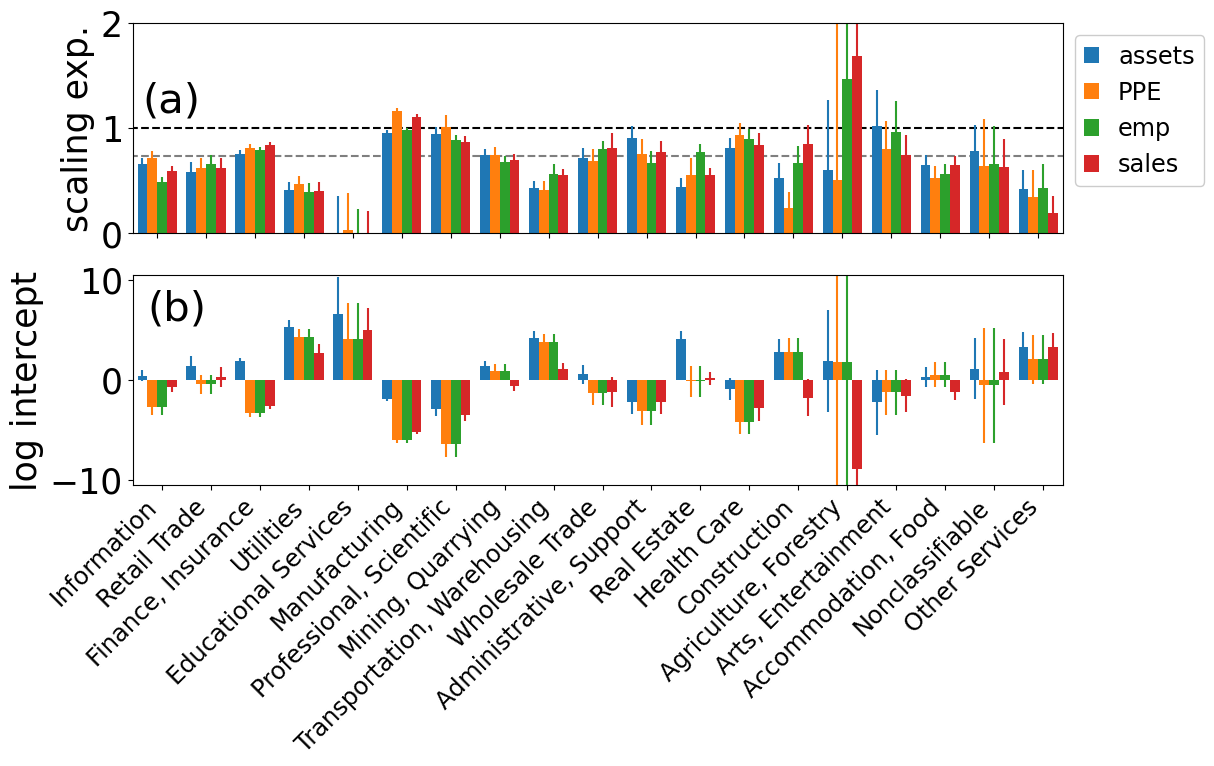

In [65]:
fig, ax = plt.subplots(figsize=(12,6), nrows=2)

h = []
ax[0].hlines(1, -1, 19, linestyles='--', color='k', zorder=-1)
ax[0].hlines(.73, -1, 19, linestyles='--', color='k', alpha=.5, zorder=-1)

y = [i[0] for k, i in soln.items() if k[0]=='asset']
yerr = [i[0] for k, i in errs.items() if k[0]=='asset']
h.append(ax[0].bar(np.arange(19)-.3, y, width=.2)[0])
ax[0].errorbar(np.arange(19)-.3, y, yerr, markersize=0, fmt='.')

y = [i[0] for k, i in soln.items() if k[0]=='plantpropertyequipment']
yerr = [i[0] for k, i in errs.items() if k[0]=='plantpropertyequipment']
h.append(ax[0].bar(np.arange(19)-.1, y, width=.2)[0])
ax[0].errorbar(np.arange(19)-.1, y, yerr, markersize=0, fmt='.')

y = [i[0] for k, i in soln.items() if k[0]=='annual_employees']
yerr = [i[0] for k, i in errs.items() if k[0]=='annual_employees']
h.append(ax[0].bar(np.arange(19)+.1, [i[0] for k, i in soln.items() if k[0]=='annual_employees'], width=.2)[0])
ax[0].errorbar(np.arange(19)+.1, y, yerr, markersize=0, fmt='.')

y = [i[0] for k, i in soln.items() if k[0]=='sales']
yerr = [i[0] for k, i in errs.items() if k[0]=='sales']
h.append(ax[0].bar(np.arange(19)+.3, [i[0] for k, i in soln.items() if k[0]=='sales'], width=.2)[0])
ax[0].errorbar(np.arange(19)+.3, y, yerr, markersize=0, fmt='.')

ax[0].legend(h, ('assets', 'PPE', 'emp', 'sales'), fontsize='x-small',
             handlelength=.6, ncols=1, framealpha=1, bbox_to_anchor=(1., 1))
ax[0].set(xticks=range(19), ylabel='scaling exp.', xlim=(-.5, 18.5), ylim=(0,2))

labels = [' '.join(i.replace(', and ',', ').replace(' and ',', ').split(' ')[:2]) for i in df['def'].dropna().unique()]
labels = [i[:-1] if i[-1]==',' else i for i in labels]
ax[0].set_xticklabels([])


h = []
y = [i[1] for k, i in soln.items() if k[0]=='asset']
yerr = [i[1] for k, i in errs.items() if k[0]=='asset']
h.append(ax[1].bar(np.arange(19)-.4, y, width=.2)[0])
h.append(ax[1].errorbar(np.arange(19)-.4, y, yerr, markersize=0, fmt='.')[0])

y = [i[1] for k, i in soln.items() if k[0]=='plantpropertyequipment']
yerr = [i[1] for k, i in errs.items() if k[0]=='plantpropertyequipment']
h.append(ax[1].bar(np.arange(19)-.2, y, width=.2)[0])
h.append(ax[1].errorbar(np.arange(19)-.2, y, yerr, markersize=0, fmt='.')[0])

y = [i[1] for k, i in soln.items() if k[0]=='plantpropertyequipment']
yerr = [i[1] for k, i in errs.items() if k[0]=='plantpropertyequipment']
h.append(ax[1].bar(np.arange(19), y, width=.2)[0])
h.append(ax[1].errorbar(np.arange(19), y, yerr, markersize=0, fmt='.')[0])

y = [i[1] for k, i in soln.items() if k[0]=='sales']
yerr = [i[1] for k, i in errs.items() if k[0]=='sales']
h.append(ax[1].bar(np.arange(19)+.2, y, width=.2)[0])
h.append(ax[1].errorbar(np.arange(19)+.2, y, yerr, markersize=0, fmt='.')[0])

ax[1].set(xticks=range(19), ylabel='log intercept', xlim=(-.6, 18.4), ylim=(-10.5, 10.5))
ax[1].set_xticklabels(labels, rotation=45, fontsize='x-small', ha='right');

ax[0].text(.3, 1.15, '(a)', fontsize='large', ha='center')
ax[1].text(.3, 6, '(b)', fontsize='large', ha='center')

fig.savefig(f'{imgdr}/sector_fits.pdf', bbox_inches='tight')

# Relevancy cutoff

In [58]:
conn = db.connect(f'{FIREHOSE_PATH}/good_domains.db')
scores = conn.execute('SELECT * FROM scores').fetchdf()
scores = scores.dropna()

percentile_cutoff = np.percentile(scores['avg_rlvcy'], 5)
ecdf = ECDF(scores['avg_rlvcy'].values)

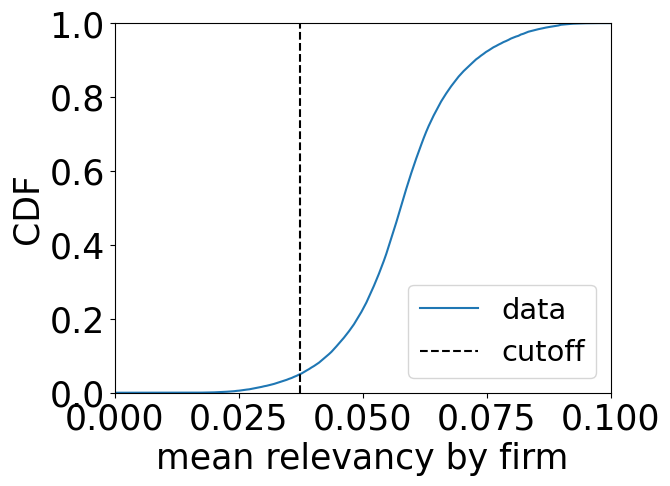

In [59]:
fig, ax = plt.subplots()

x = np.linspace(0, .1, 200)
ax.plot(x, ecdf(x))
ax.vlines(percentile_cutoff, 0, 1, linestyles='--', color='k')
ax.set(xlabel='mean relevancy by firm', ylabel='CDF', xlim=(0,.1), ylim=(0,1))
ax.legend(('data', 'cutoff'), fontsize='small', loc=4)

fig.savefig(f'{imgdr}/rlvcy_cutoff.pdf', bbox_inches='tight')

# Devices per employee

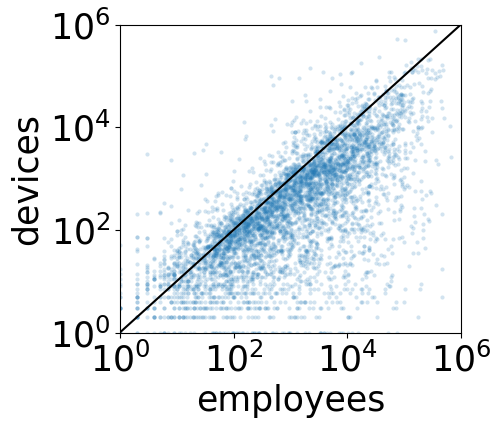

In [60]:
load_pickle('./cache/devices2employees.p')

fig, ax = plt.subplots(figsize=(4.4,4))
ax.loglog(df['emp']*1000, df['devices'], '.', mew=0, alpha=.2)
x = np.array([1, 1000000])
ax.loglog(x, x, 'k-')
ax.yaxis.set_tick_params(which='minor', length=0)
ax.set(xlabel='employees', ylabel='devices', xlim=(1, 1e6), ylim=(1,1e6))

fig.savefig(f'{imgdr}/devices2employees.pdf', bbox_inches='tight')

# Heaps fit errors

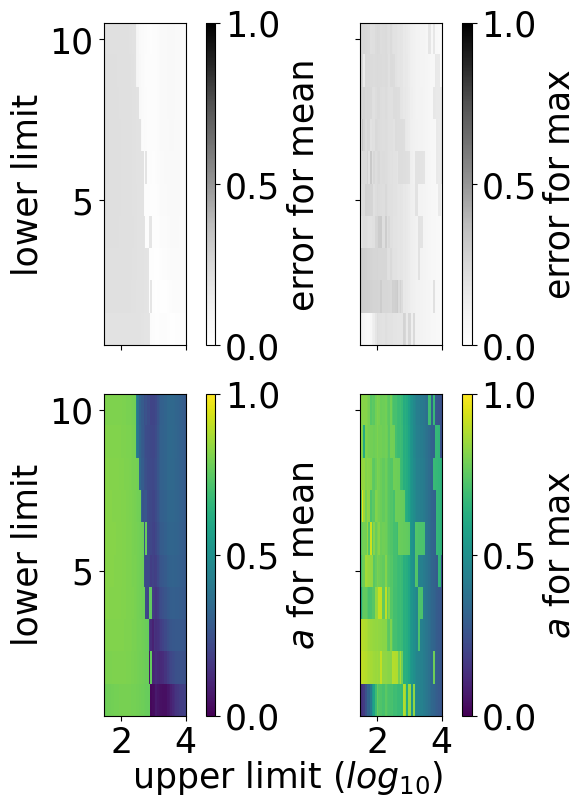

In [61]:
load_pickle('cache/heaps_fitting_variation.p')

fig = plt.figure(figsize=(5,9))
gs = GridSpec(2, 2, wspace=.95, hspace=.15)
gs1 = GridSpecFromSubplotSpec(1, 2, gs[0,0], width_ratios=(1,.08), wspace=.01)
gs2 = GridSpecFromSubplotSpec(1, 2, gs[0,1], width_ratios=(1,.08), wspace=.01)
gs3 = GridSpecFromSubplotSpec(1, 2, gs[1,0], width_ratios=(1,.08), wspace=.01)
gs4 = GridSpecFromSubplotSpec(1, 2, gs[1,1], width_ratios=(1,.08), wspace=.01)
ax = (fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1]),
      fig.add_subplot(gs2[0]), fig.add_subplot(gs2[1]),
      fig.add_subplot(gs3[0]), fig.add_subplot(gs3[1]),
      fig.add_subplot(gs4[0]), fig.add_subplot(gs4[1]))

cax = ax[0].imshow(m_err, extent=np.concatenate((np.log10([upper_range[0]-.5, upper_range[-1]+.5]),
                                                 [lower_range[0]-.5, lower_range[-1]+.5])),
                interpolation='none', cmap='Greys', origin='lower', vmin=0, vmax=1)
ax[0].set(ylabel='lower limit', yticks=[5,10], xticklabels=[])
fig.colorbar(cax, cax=ax[1], label='error for mean', ticks=[0,.5,1])

cax = ax[2].imshow(mx_err, extent=np.concatenate((np.log10([upper_range[0]-.5, upper_range[-1]+.5]),
                                                 [lower_range[0]-.5, lower_range[-1]+.5])),
                interpolation='none', cmap='Greys', origin='lower', vmin=0, vmax=1)
ax[2].set(yticklabels=[], xticklabels=[], yticks=[5,10])
fig.colorbar(cax, cax=ax[3], label='error for max', ticks=[0,.5,1])

cax = ax[4].imshow(a_mean, extent=np.concatenate((np.log10([upper_range[0]-.5, upper_range[-1]+.5]),
                                                   [lower_range[0]-.5, lower_range[-1]+.5])),
                interpolation='none', cmap='viridis', origin='lower', vmin=0, vmax=1)
ax[4].set(yticks=[5,10], ylabel='lower limit')
fig.colorbar(cax, cax=ax[5], label=r'$a$ for mean', ticks=[0,.5,1])

cax = ax[6].imshow(a_max, extent=np.concatenate((np.log10([upper_range[0]-.5, upper_range[-1]+.5]),
                                                   [lower_range[0]-.5, lower_range[-1]+.5])),
                interpolation='none', cmap='viridis', origin='lower', vmin=0, vmax=1)
ax[6].set(yticklabels=[], yticks=[5,10])
fig.colorbar(cax, cax=ax[7], label=r'$a$ for max', ticks=[0,.5,1])
fig.text(.5, .03, r'   upper limit ($log_{10}$)', ha='center')

fig.savefig(f'{imgdr}/heaps_fit_variation.pdf', bbox_inches='tight')

/tmp/ipykernel_1734158/1297333992.py:7: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(color='white', edgecolor='black', label='reject')]


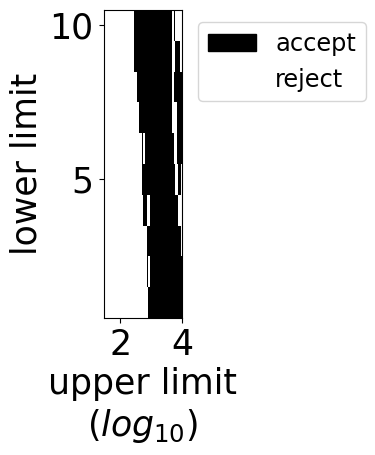

In [62]:
fig, ax = plt.subplots(figsize=(6,4))
ix = ((a_max-a_mean)>=0) & (m_err<.1)
cax = ax.imshow(ix, extent=np.concatenate((np.log10([upper_range[0]-.5, upper_range[-1]+.5]),
                                                 [lower_range[0]-.5, lower_range[-1]+.5])),
                interpolation='none', cmap='Greys', origin='lower')
patches = [Patch(color='black', label='accept'),
           Patch(color='white', edgecolor='black', label='reject')]
ax.legend(handles=patches, fontsize='x-small', bbox_to_anchor=(3.5,1), loc=1)
ax.set(xlabel='upper limit\n'+r'($log_{10}$)', ylabel='lower limit', yticks=[5,10])
fig.savefig(f'{imgdr}/accept_fits.pdf', bbox_inches='tight')